# Numba performance enhancements

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Numpy" data-toc-modified-id="Numpy-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Numpy</a></span><ul class="toc-item"><li><span><a href="#The-bad-way" data-toc-modified-id="The-bad-way-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>The bad way</a></span></li><li><span><a href="#A-better-way" data-toc-modified-id="A-better-way-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>A better way</a></span></li><li><span><a href="#Viewing-the-image" data-toc-modified-id="Viewing-the-image-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Viewing the image</a></span></li></ul></li><li><span><a href="#Numba-@jit,-serial" data-toc-modified-id="Numba-@jit,-serial-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Numba @jit, serial</a></span></li><li><span><a href="#Numba-@jit,-parallel" data-toc-modified-id="Numba-@jit,-parallel-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Numba @jit, parallel</a></span></li><li><span><a href="#Numba-@vectorize" data-toc-modified-id="Numba-@vectorize-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Numba @vectorize</a></span></li><li><span><a href="#CUDA" data-toc-modified-id="CUDA-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>CUDA</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

## Introduction

The Julia set example is based on Gorelick, "High Performance Python: Practical Performant Programming for Humans", as it gives us something simple and CPU-intensive to work with.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

Area of complex space to investigate, as global variables:

In [2]:
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193
c = complex(c_real, c_imag)

Set reasonable defaults for a laptop

In [3]:
desired_width = 1000
max_iterations = 300

In [4]:
def set_coords():
    x_step = (x2 - x1) / desired_width
    y_step = (y2 - y1) / desired_width
    x = np.arange(x1, x2, x_step)
    y = np.arange(y1, y2, y_step)

    # set width and height to the generated pixel counts, rather than the
    # pre-rounding desired width and height
    width = len(x)
    height = len(y)
    
    # build a list of co-ordinates 
    zs = [complex(xcoord, ycoord) for ycoord in y for xcoord in x]
    return np.array(zs), width, height

In [5]:
zs, width, height = set_coords()
zlen = len(zs)

## Numpy

### The bad way

In [6]:
def calculate_z_serial_numpy():
    """Calculate output list using Julia update rule"""
    output = np.zeros(zlen)
    for i in range(zlen):
        n = 0
        z = zs[i]
        while abs(z) < 2 and n < max_iterations:
            z = z*z + c
            n += 1
        output[i] = n
    return output

In [7]:
def calc_numpy():
    output = calculate_z_serial_numpy()

    # this sum is expected for 1000^2 grid with 300 iterations
    assert sum(output) == 33219980

    return output

In [23]:
%time output = calc_numpy()

CPU times: user 23.9 s, sys: 0 ns, total: 23.9 s
Wall time: 23.9 s


This is really slow!

### A better way

Split out the per-pixel calculation and let Numpy vectorize it.

In [9]:
def calc_iter(z):
    n = 0
    while abs(z) < 2 and n < max_iterations:
        z = z*z + c
        n += 1
    return n

In [24]:
calc_iter_vec = np.vectorize(calc_iter)
%time output = calc_iter_vec(zs)

CPU times: user 7.6 s, sys: 31.8 ms, total: 7.63 s
Wall time: 7.63 s


About a 3-fold improvement.

### Viewing the image

In [11]:
def show_image(output_raw):
    
    # sanity check our 1D array and desired 2D form
    assert width * height == len(output_raw)
    
    output_raw = np.array(output_raw)
    plt.imshow(output_raw.reshape((width, height)), origin='lower') #, cmap='Greys')

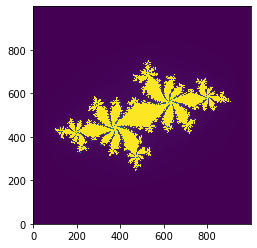

In [12]:
show_image(output)

## Numba @jit, serial

In [13]:
from numba.decorators import jit

@jit(nopython=True)
def calc_iter_jit(z):
    n = 0
    while abs(z) < 2 and n < max_iterations:
        z = z*z + c
        n += 1
    return n

@jit(nopython=True)
def calculate_z_serial_jit():
    output = np.zeros(zlen)
    for i in range(len(zs)):
        output[i] = calc_iter_jit(zs[i])
    return output

In [14]:
def calc_jit():
    output = calculate_z_serial_jit()

    # this sum is expected for 1000^2 grid with 300 iterations
    assert sum(output) == 33219980

    return output

In [15]:
%timeit output = calc_jit()

548 ms ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numba @jit, parallel

In [16]:
@jit(nopython=True, parallel=True)
def calculate_z_parallel_jit():
    output = np.zeros(zlen)
    for i in range(len(zs)):
        output[i] = calc_iter_jit(zs[i])
    return output

In [17]:
def calc_jit_parallel():
    output = calculate_z_parallel_jit()

    # this sum is expected for 1000^2 grid with 300 iterations
    assert sum(output) == 33219980

    return output

In [18]:
%timeit output = calc_jit_parallel()

636 ms ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It got slightly worse!

## Numba @vectorize

In [19]:
from numba import vectorize, complex128

@vectorize([complex128(complex128)])
def calc_iter_numba_vec(z):
    n = 0
    while abs(z) < 2 and n < max_iterations:
        z = z*z + c
        n += 1
    return n

# no @jit here: it wouldn't help and also conflicts with assert()
def calculate_z_numba_vec():
    output = calc_iter_numba_vec(zs)
    
    # this sum is expected for 1000^2 grid with 300 iterations
    assert sum(output) == 33219980
    
    return output

In [20]:
%timeit output = calculate_z_numba_vec()

555 ms ± 6.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That's about the same as @jit serial.

## CUDA

This depends on specific hardware and drivers. Will it work here?

In [27]:
from numba import cuda

if cuda.is_available():
    cuda.detect()
else:
    print("CUDA is not available on this machine")

CUDA is not available on this machine


The simplest usage is in the @vectorize decorator. This will throw CUDA_ERROR_UNKNOWN on machines lacking a CUDA-capable graphics system.

In [26]:
@vectorize([complex128(complex128)], target='cuda')
def calc_iter_numba_cuda(z):
    n = 0
    while abs(z) < 2 and n < max_iterations:
        z = z*z + c
        n += 1
    return n

# no @jit here: it wouldn't help and also conflicts with assert()
def calculate_z_numba_cuda():
    output = calc_iter_numba_cuda(zs)
    
    # this sum is expected for 1000^2 grid with 300 iterations
    assert sum(output) == 33219980
    
    return output

In [22]:
%timeit output = calculate_z_numba_cuda()

CudaSupportError: Error at driver init: 
[999] Call to cuInit results in CUDA_ERROR_UNKNOWN:

## Results

This notebook, plus the Julia version, were run on various machines I had access to. Timings in seconds were:
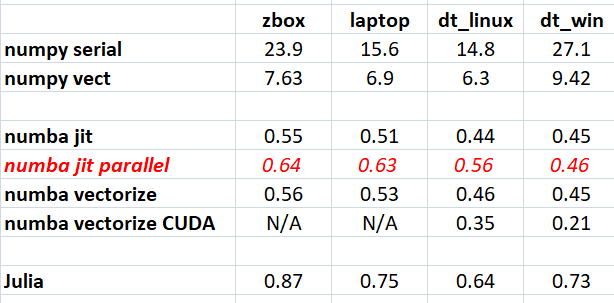

The hardware was a fanless Zbox and an Acer laptop, both with i5 CPUs, and 2 desktop PCs with i7 CPUs. The first 3 ran Linux Mint 19.2, the last Windows 10.

Only the desktops had Nvidia graphics cards: a cheap GT 710 in the Linux box and a more capable GTX 1050 for the Windows system.

Apparently, to get much speedup with CUDA you need to pay for decent hardware.